
### CLASIFICADOR DE IMÁGENES FROM SCRATCH CNN



Para este modelo se han seleccionado únicamente los siguientes 10 deportes:
*   football
*   bowling
*   basketball
*   baseball
*   boxing
*   polo
*   formula 1 racing
*   hockey
*   tennis
*   swimming

Esto se debe a la alta complejidad que supone la clasificación entre 100 clases utilizando un modelo sin pre-entrenar. Además, debido a la capacidad de cómputo limitada para la optimización de parámetros, únicamente se ha realizado la búsqueda de el número de filtros para la segunda capa y el número de neuronas para la primera capa Dense del clasificador.

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.1 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.metrics import classification_report

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras import applications
import os
import cv2
import optuna

import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D
from keras.layers import AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPool2D,MaxPooling2D,MaxPool2D,Dropout
from keras.models import Model,Sequential
from keras.layers import Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(224, 224, 3)


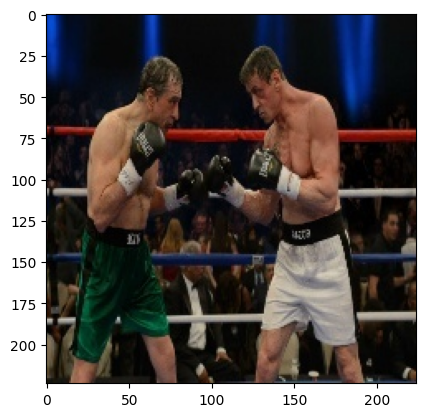

In [9]:
#Leemos una imágen para ver cómo son
img = cv2.imread('/content/drive/MyDrive/No estructurados/Practica/scratch/train/boxing/001.jpg')
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img1)

In [10]:
#Contamos con 10 clases para clasificar con el objetivo de agilizar
clases = os.listdir('/content/drive/MyDrive/No estructurados/Practica/scratch/train')
print(clases)
print(len(clases))

['hockey', 'tennis', 'baseball', 'swimming', 'polo', 'basketball', 'formula 1 racing', 'boxing', 'football', 'bowling']
10


In [11]:
train_data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/No estructurados/Practica/scratch/train',label_mode='categorical',shuffle=False)
test_data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/No estructurados/Practica/scratch/test',shuffle=False,label_mode='categorical')
validation_data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/No estructurados/Practica/scratch/valid',label_mode='categorical',shuffle=False)

Found 1577 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [13]:
#Adaptamos todas las imágenes para que estén en mismo formato (224,224,3) por si hay alguna con dimensiones distintas
width = 224
height = 224
channels = 3

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(height, width),
    tf.keras.layers.Rescaling(1.0 / 255),

])
train_ds=train_data.map(lambda x,y:(data_preprocessing(x),y))
test_ds=test_data.map(lambda x,y:(data_preprocessing(x),y))
valid_ds=validation_data.map(lambda x,y:(data_preprocessing(x),y))

In [14]:
# Cargamos los 3 datasets: train, test y validación
batch_size = 20
train_dataGen = ImageDataGenerator()
test_dataGen = ImageDataGenerator()
valid_dataGen = ImageDataGenerator()

train_generator = train_dataGen.flow_from_directory(
        '/content/drive/MyDrive/No estructurados/Practica/scratch/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True,  seed = 42)

test_generator = test_dataGen.flow_from_directory(
        '/content/drive/MyDrive/No estructurados/Practica/scratch/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False,seed = 42)

validation_generator = valid_dataGen.flow_from_directory(
        '/content/drive/MyDrive/No estructurados/Practica/scratch/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False,seed = 42)

Found 1577 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [15]:
# Definimos early stopping para detener ejecución si no mejora la loss de validación en 5 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Optimización de parámetros utilizando Optuna
def objective(trial):
    units = trial.suggest_int('units', 32, 512)  # Rango de valores para units
    filters = trial.suggest_int('filters', 16, 128)  # Rango de valores para filters

    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=filters, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=units, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=10, activation="softmax"))  # 10 unidades para salida, por las clases

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenamiento del modelo
    model.fit(train_generator, epochs=20, validation_data=validation_generator,validation_steps=50 // batch_size,callbacks=early_stopping)

    # Evaluación del modelo
    _, accuracy = model.evaluate(test_generator)

    return accuracy


# Ejecutar optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Obtener los mejores hiperparámetros encontrados
best_units = study.best_params['units']
best_filters = study.best_params['filters']

print("Mejor número de units:", best_units)
print("Mejor número de filters:", best_filters)


[I 2024-05-01 16:21:48,700] A new study created in memory with name: no-name-42d3b152-d81d-424c-b3bc-8489c039dadc


Epoch 1/20
79/79 [==============================] - 406s 5s/step - loss: 144.0096 - accuracy: 0.1218 - val_loss: 2.2913 - val_accuracy: 0.1000
Epoch 2/20
79/79 [==============================] - 14s 173ms/step - loss: 2.1847 - accuracy: 0.2004 - val_loss: 2.1648 - val_accuracy: 0.2250
Epoch 3/20
79/79 [==============================] - 14s 175ms/step - loss: 2.0005 - accuracy: 0.2841 - val_loss: 2.0722 - val_accuracy: 0.3000
Epoch 4/20
79/79 [==============================] - 14s 174ms/step - loss: 1.8474 - accuracy: 0.3367 - val_loss: 1.9496 - val_accuracy: 0.4250
Epoch 5/20
79/79 [==============================] - 14s 174ms/step - loss: 1.6346 - accuracy: 0.4185 - val_loss: 1.8062 - val_accuracy: 0.5000
Epoch 6/20
79/79 [==============================] - 14s 174ms/step - loss: 1.5317 - accuracy: 0.4705 - val_loss: 1.8325 - val_accuracy: 0.4250
Epoch 7/20
79/79 [==============================] - 14s 174ms/step - loss: 1.2811 - accuracy: 0.5745 - val_loss: 1.8968 - val_accuracy: 0.4750

[I 2024-05-01 16:31:16,813] Trial 0 finished with value: 0.4000000059604645 and parameters: {'units': 359, 'filters': 86}. Best is trial 0 with value: 0.4000000059604645.


Epoch 1/20
79/79 [==============================] - 14s 129ms/step - loss: 29.2763 - accuracy: 0.1420 - val_loss: 2.0355 - val_accuracy: 0.2250
Epoch 2/20
79/79 [==============================] - 8s 101ms/step - loss: 1.9664 - accuracy: 0.3145 - val_loss: 1.6893 - val_accuracy: 0.4250
Epoch 3/20
79/79 [==============================] - 8s 97ms/step - loss: 1.6266 - accuracy: 0.4502 - val_loss: 1.3890 - val_accuracy: 0.5500
Epoch 4/20
79/79 [==============================] - 8s 103ms/step - loss: 1.2264 - accuracy: 0.5758 - val_loss: 1.3378 - val_accuracy: 0.5000
Epoch 5/20
79/79 [==============================] - 8s 94ms/step - loss: 0.8736 - accuracy: 0.7051 - val_loss: 1.4096 - val_accuracy: 0.4750
Epoch 6/20
79/79 [==============================] - 7s 92ms/step - loss: 0.6129 - accuracy: 0.7952 - val_loss: 1.7872 - val_accuracy: 0.3750
Epoch 7/20
79/79 [==============================] - 7s 92ms/step - loss: 0.5155 - accuracy: 0.8301 - val_loss: 1.5572 - val_accuracy: 0.4500
Epoch 8/

[I 2024-05-01 16:32:41,495] Trial 1 finished with value: 0.6000000238418579 and parameters: {'units': 203, 'filters': 17}. Best is trial 1 with value: 0.6000000238418579.


Epoch 1/20
79/79 [==============================] - 17s 146ms/step - loss: 84.1669 - accuracy: 0.1287 - val_loss: 2.2856 - val_accuracy: 0.2500
Epoch 2/20
79/79 [==============================] - 9s 112ms/step - loss: 2.2185 - accuracy: 0.1680 - val_loss: 2.0257 - val_accuracy: 0.3750
Epoch 3/20
79/79 [==============================] - 9s 107ms/step - loss: 2.0291 - accuracy: 0.2689 - val_loss: 1.9047 - val_accuracy: 0.3250
Epoch 4/20
79/79 [==============================] - 8s 103ms/step - loss: 1.7670 - accuracy: 0.3729 - val_loss: 2.1148 - val_accuracy: 0.3500
Epoch 5/20
79/79 [==============================] - 9s 110ms/step - loss: 1.4923 - accuracy: 0.4724 - val_loss: 2.1641 - val_accuracy: 0.4000
Epoch 6/20
79/79 [==============================] - 9s 110ms/step - loss: 1.1695 - accuracy: 0.5954 - val_loss: 2.0772 - val_accuracy: 0.3500
Epoch 7/20
79/79 [==============================] - 8s 102ms/step - loss: 1.0375 - accuracy: 0.6430 - val_loss: 2.2826 - val_accuracy: 0.4250
Epoc

[I 2024-05-01 16:34:08,187] Trial 2 finished with value: 0.25999999046325684 and parameters: {'units': 201, 'filters': 39}. Best is trial 1 with value: 0.6000000238418579.


Epoch 1/20
79/79 [==============================] - 16s 141ms/step - loss: 72.5997 - accuracy: 0.1427 - val_loss: 2.1452 - val_accuracy: 0.2750
Epoch 2/20
79/79 [==============================] - 9s 111ms/step - loss: 2.1011 - accuracy: 0.2594 - val_loss: 2.0301 - val_accuracy: 0.2250
Epoch 3/20
79/79 [==============================] - 9s 108ms/step - loss: 1.7873 - accuracy: 0.3824 - val_loss: 1.9471 - val_accuracy: 0.3000
Epoch 4/20
79/79 [==============================] - 8s 102ms/step - loss: 1.4180 - accuracy: 0.5098 - val_loss: 1.9484 - val_accuracy: 0.4250
Epoch 5/20
79/79 [==============================] - 9s 107ms/step - loss: 1.0948 - accuracy: 0.6259 - val_loss: 2.0872 - val_accuracy: 0.4000
Epoch 6/20
79/79 [==============================] - 9s 109ms/step - loss: 0.8925 - accuracy: 0.6988 - val_loss: 2.4520 - val_accuracy: 0.4000
Epoch 7/20
79/79 [==============================] - 8s 101ms/step - loss: 0.6930 - accuracy: 0.7666 - val_loss: 2.6426 - val_accuracy: 0.4500
Epoc

[I 2024-05-01 16:35:27,435] Trial 3 finished with value: 0.30000001192092896 and parameters: {'units': 335, 'filters': 33}. Best is trial 1 with value: 0.6000000238418579.


Epoch 1/20
79/79 [==============================] - 14s 127ms/step - loss: 47.1153 - accuracy: 0.1344 - val_loss: 2.1692 - val_accuracy: 0.2250
Epoch 2/20
79/79 [==============================] - 8s 102ms/step - loss: 2.1244 - accuracy: 0.2365 - val_loss: 2.0109 - val_accuracy: 0.3000
Epoch 3/20
79/79 [==============================] - 8s 96ms/step - loss: 1.9400 - accuracy: 0.3114 - val_loss: 1.7717 - val_accuracy: 0.3000
Epoch 4/20
79/79 [==============================] - 8s 94ms/step - loss: 1.6417 - accuracy: 0.4242 - val_loss: 1.8580 - val_accuracy: 0.2750
Epoch 5/20
79/79 [==============================] - 8s 103ms/step - loss: 1.4526 - accuracy: 0.4978 - val_loss: 1.6020 - val_accuracy: 0.4500
Epoch 6/20
79/79 [==============================] - 8s 98ms/step - loss: 1.2260 - accuracy: 0.5866 - val_loss: 2.1359 - val_accuracy: 0.3750
Epoch 7/20
79/79 [==============================] - 7s 91ms/step - loss: 1.0749 - accuracy: 0.6309 - val_loss: 1.9222 - val_accuracy: 0.4000
Epoch 8/

[I 2024-05-01 16:37:00,652] Trial 4 finished with value: 0.41999998688697815 and parameters: {'units': 140, 'filters': 29}. Best is trial 1 with value: 0.6000000238418579.


Epoch 1/20
79/79 [==============================] - 18s 159ms/step - loss: 183.1894 - accuracy: 0.1065 - val_loss: 2.3000 - val_accuracy: 0.1250
Epoch 2/20
79/79 [==============================] - 10s 121ms/step - loss: 2.2458 - accuracy: 0.1636 - val_loss: 2.2477 - val_accuracy: 0.1750
Epoch 3/20
79/79 [==============================] - 10s 121ms/step - loss: 2.0761 - accuracy: 0.2536 - val_loss: 2.1737 - val_accuracy: 0.2250
Epoch 4/20
79/79 [==============================] - 10s 124ms/step - loss: 1.9881 - accuracy: 0.2936 - val_loss: 2.1142 - val_accuracy: 0.3250
Epoch 5/20
79/79 [==============================] - 10s 121ms/step - loss: 1.7709 - accuracy: 0.3672 - val_loss: 2.1672 - val_accuracy: 0.3500
Epoch 6/20
79/79 [==============================] - 10s 122ms/step - loss: 1.5040 - accuracy: 0.4750 - val_loss: 1.8983 - val_accuracy: 0.4250
Epoch 7/20
79/79 [==============================] - 9s 117ms/step - loss: 1.3961 - accuracy: 0.5041 - val_loss: 2.0592 - val_accuracy: 0.450

[I 2024-05-01 16:38:58,301] Trial 5 finished with value: 0.3799999952316284 and parameters: {'units': 417, 'filters': 48}. Best is trial 1 with value: 0.6000000238418579.


Epoch 1/20
79/79 [==============================] - 27s 257ms/step - loss: 40.9331 - accuracy: 0.1300 - val_loss: 2.2937 - val_accuracy: 0.1000
Epoch 2/20
79/79 [==============================] - 16s 198ms/step - loss: 2.1417 - accuracy: 0.2036 - val_loss: 2.1510 - val_accuracy: 0.3000
Epoch 3/20
79/79 [==============================] - 16s 198ms/step - loss: 1.8334 - accuracy: 0.3589 - val_loss: 1.5877 - val_accuracy: 0.5000
Epoch 4/20
79/79 [==============================] - 16s 197ms/step - loss: 1.5207 - accuracy: 0.4845 - val_loss: 1.6450 - val_accuracy: 0.4500
Epoch 5/20
79/79 [==============================] - 16s 199ms/step - loss: 1.3173 - accuracy: 0.5555 - val_loss: 1.3496 - val_accuracy: 0.6000
Epoch 6/20
79/79 [==============================] - 16s 198ms/step - loss: 1.0584 - accuracy: 0.6424 - val_loss: 1.2961 - val_accuracy: 0.6500
Epoch 7/20
79/79 [==============================] - 16s 196ms/step - loss: 0.9213 - accuracy: 0.7020 - val_loss: 0.9141 - val_accuracy: 0.700

[I 2024-05-01 16:42:40,586] Trial 6 finished with value: 0.699999988079071 and parameters: {'units': 233, 'filters': 100}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 23s 213ms/step - loss: 70.5102 - accuracy: 0.1801 - val_loss: 2.1900 - val_accuracy: 0.2000
Epoch 2/20
79/79 [==============================] - 13s 166ms/step - loss: 1.9267 - accuracy: 0.3164 - val_loss: 1.7364 - val_accuracy: 0.4250
Epoch 3/20
79/79 [==============================] - 13s 162ms/step - loss: 1.6374 - accuracy: 0.4249 - val_loss: 1.8002 - val_accuracy: 0.4500
Epoch 4/20
79/79 [==============================] - 13s 165ms/step - loss: 1.4196 - accuracy: 0.5048 - val_loss: 1.4118 - val_accuracy: 0.5000
Epoch 5/20
79/79 [==============================] - 13s 164ms/step - loss: 1.1544 - accuracy: 0.6043 - val_loss: 1.7163 - val_accuracy: 0.4500
Epoch 6/20
79/79 [==============================] - 13s 164ms/step - loss: 0.8766 - accuracy: 0.6912 - val_loss: 1.6879 - val_accuracy: 0.5500
Epoch 7/20
79/79 [==============================] - 13s 164ms/step - loss: 0.7157 - accuracy: 0.7660 - val_loss: 2.0118 - val_accuracy: 0.475

[I 2024-05-01 16:45:04,726] Trial 7 finished with value: 0.5199999809265137 and parameters: {'units': 363, 'filters': 74}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 16s 141ms/step - loss: 55.1688 - accuracy: 0.1211 - val_loss: 2.1849 - val_accuracy: 0.2000
Epoch 2/20
79/79 [==============================] - 9s 111ms/step - loss: 2.2027 - accuracy: 0.1833 - val_loss: 2.1905 - val_accuracy: 0.2250
Epoch 3/20
79/79 [==============================] - 8s 101ms/step - loss: 2.0796 - accuracy: 0.2594 - val_loss: 2.0689 - val_accuracy: 0.1750
Epoch 4/20
79/79 [==============================] - 9s 110ms/step - loss: 1.9078 - accuracy: 0.3348 - val_loss: 1.8275 - val_accuracy: 0.2500
Epoch 5/20
79/79 [==============================] - 9s 114ms/step - loss: 1.7200 - accuracy: 0.4027 - val_loss: 1.8580 - val_accuracy: 0.3000
Epoch 6/20
79/79 [==============================] - 8s 102ms/step - loss: 1.6191 - accuracy: 0.4540 - val_loss: 1.7240 - val_accuracy: 0.3500
Epoch 7/20
79/79 [==============================] - 9s 110ms/step - loss: 1.4184 - accuracy: 0.5079 - val_loss: 1.7701 - val_accuracy: 0.3250
Epoc

[I 2024-05-01 16:46:48,878] Trial 8 finished with value: 0.3199999928474426 and parameters: {'units': 199, 'filters': 37}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 18s 167ms/step - loss: 19.6640 - accuracy: 0.1091 - val_loss: 2.3003 - val_accuracy: 0.1250
Epoch 2/20
79/79 [==============================] - 10s 129ms/step - loss: 2.2995 - accuracy: 0.1211 - val_loss: 2.2991 - val_accuracy: 0.1250
Epoch 3/20
79/79 [==============================] - 11s 132ms/step - loss: 2.2977 - accuracy: 0.1211 - val_loss: 2.2981 - val_accuracy: 0.1250
Epoch 4/20
79/79 [==============================] - 10s 127ms/step - loss: 2.2959 - accuracy: 0.1211 - val_loss: 2.2968 - val_accuracy: 0.1250
Epoch 5/20
79/79 [==============================] - 10s 128ms/step - loss: 2.2946 - accuracy: 0.1211 - val_loss: 2.2953 - val_accuracy: 0.1250
Epoch 6/20
79/79 [==============================] - 10s 128ms/step - loss: 2.2935 - accuracy: 0.1211 - val_loss: 2.2957 - val_accuracy: 0.1250
Epoch 7/20
79/79 [==============================] - 10s 129ms/step - loss: 2.2927 - accuracy: 0.1211 - val_loss: 2.2949 - val_accuracy: 0.125

[I 2024-05-01 16:50:03,269] Trial 9 finished with value: 0.10000000149011612 and parameters: {'units': 36, 'filters': 64}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 30s 293ms/step - loss: 52.8710 - accuracy: 0.1579 - val_loss: 2.2529 - val_accuracy: 0.1750
Epoch 2/20
79/79 [==============================] - 18s 229ms/step - loss: 1.9416 - accuracy: 0.3107 - val_loss: 2.0086 - val_accuracy: 0.3000
Epoch 3/20
79/79 [==============================] - 18s 227ms/step - loss: 1.6095 - accuracy: 0.4426 - val_loss: 1.7901 - val_accuracy: 0.3750
Epoch 4/20
79/79 [==============================] - 18s 227ms/step - loss: 1.2883 - accuracy: 0.5599 - val_loss: 1.7498 - val_accuracy: 0.3750
Epoch 5/20
79/79 [==============================] - 18s 227ms/step - loss: 1.0244 - accuracy: 0.6614 - val_loss: 1.7056 - val_accuracy: 0.5250
Epoch 6/20
79/79 [==============================] - 18s 225ms/step - loss: 0.7236 - accuracy: 0.7628 - val_loss: 1.9902 - val_accuracy: 0.3750
Epoch 7/20
79/79 [==============================] - 18s 225ms/step - loss: 0.4785 - accuracy: 0.8408 - val_loss: 2.3260 - val_accuracy: 0.500

[I 2024-05-01 16:53:22,271] Trial 10 finished with value: 0.5199999809265137 and parameters: {'units': 506, 'filters': 128}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 28s 262ms/step - loss: 44.8125 - accuracy: 0.1078 - val_loss: 2.2976 - val_accuracy: 0.1250
Epoch 2/20
79/79 [==============================] - 16s 203ms/step - loss: 2.2267 - accuracy: 0.1807 - val_loss: 2.0785 - val_accuracy: 0.2750
Epoch 3/20
79/79 [==============================] - 16s 203ms/step - loss: 1.9984 - accuracy: 0.2993 - val_loss: 1.9073 - val_accuracy: 0.3500
Epoch 4/20
79/79 [==============================] - 16s 203ms/step - loss: 1.7141 - accuracy: 0.3957 - val_loss: 1.9327 - val_accuracy: 0.3250
Epoch 5/20
79/79 [==============================] - 16s 203ms/step - loss: 1.4257 - accuracy: 0.5022 - val_loss: 1.7456 - val_accuracy: 0.4750
Epoch 6/20
79/79 [==============================] - 16s 204ms/step - loss: 1.1535 - accuracy: 0.6107 - val_loss: 1.7545 - val_accuracy: 0.3500
Epoch 7/20
79/79 [==============================] - 16s 204ms/step - loss: 0.9730 - accuracy: 0.6766 - val_loss: 1.9097 - val_accuracy: 0.500

[I 2024-05-01 16:56:44,233] Trial 11 finished with value: 0.5 and parameters: {'units': 250, 'filters': 107}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 26s 244ms/step - loss: 45.1651 - accuracy: 0.1040 - val_loss: 2.3019 - val_accuracy: 0.1250
Epoch 2/20
79/79 [==============================] - 15s 191ms/step - loss: 2.3001 - accuracy: 0.1205 - val_loss: 2.3004 - val_accuracy: 0.1250
Epoch 3/20
79/79 [==============================] - 15s 190ms/step - loss: 2.2981 - accuracy: 0.1129 - val_loss: 2.2989 - val_accuracy: 0.1250
Epoch 4/20
79/79 [==============================] - 15s 189ms/step - loss: 2.2963 - accuracy: 0.1205 - val_loss: 2.2979 - val_accuracy: 0.1250
Epoch 5/20
79/79 [==============================] - 15s 189ms/step - loss: 2.2949 - accuracy: 0.1160 - val_loss: 2.2965 - val_accuracy: 0.1250
Epoch 6/20
79/79 [==============================] - 15s 189ms/step - loss: 2.2937 - accuracy: 0.1205 - val_loss: 2.2959 - val_accuracy: 0.1250
Epoch 7/20
79/79 [==============================] - 15s 190ms/step - loss: 2.2929 - accuracy: 0.1205 - val_loss: 2.2956 - val_accuracy: 0.125

[I 2024-05-01 17:01:19,912] Trial 12 finished with value: 0.10000000149011612 and parameters: {'units': 101, 'filters': 97}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 29s 279ms/step - loss: 67.1545 - accuracy: 0.1116 - val_loss: 2.2976 - val_accuracy: 0.1250
Epoch 2/20
79/79 [==============================] - 17s 216ms/step - loss: 2.2879 - accuracy: 0.1243 - val_loss: 2.2936 - val_accuracy: 0.1250
Epoch 3/20
79/79 [==============================] - 17s 218ms/step - loss: 2.2478 - accuracy: 0.1477 - val_loss: 2.2487 - val_accuracy: 0.2500
Epoch 4/20
79/79 [==============================] - 17s 218ms/step - loss: 2.1151 - accuracy: 0.2251 - val_loss: 2.0020 - val_accuracy: 0.3500
Epoch 5/20
79/79 [==============================] - 17s 217ms/step - loss: 1.9201 - accuracy: 0.3171 - val_loss: 1.9596 - val_accuracy: 0.3750
Epoch 6/20
79/79 [==============================] - 17s 217ms/step - loss: 1.7390 - accuracy: 0.3912 - val_loss: 1.8124 - val_accuracy: 0.4500
Epoch 7/20
79/79 [==============================] - 17s 219ms/step - loss: 1.5463 - accuracy: 0.4629 - val_loss: 1.7596 - val_accuracy: 0.350

[I 2024-05-01 17:05:43,507] Trial 13 finished with value: 0.41999998688697815 and parameters: {'units': 247, 'filters': 117}. Best is trial 6 with value: 0.699999988079071.


Epoch 1/20
79/79 [==============================] - 13s 121ms/step - loss: 47.2374 - accuracy: 0.1890 - val_loss: 1.8208 - val_accuracy: 0.4750
Epoch 2/20
79/79 [==============================] - 8s 102ms/step - loss: 1.6600 - accuracy: 0.4375 - val_loss: 1.5117 - val_accuracy: 0.5000
Epoch 3/20
79/79 [==============================] - 8s 94ms/step - loss: 1.2148 - accuracy: 0.5821 - val_loss: 1.1277 - val_accuracy: 0.5750
Epoch 4/20
79/79 [==============================] - 7s 89ms/step - loss: 0.9470 - accuracy: 0.6906 - val_loss: 1.4354 - val_accuracy: 0.4750
Epoch 5/20
79/79 [==============================] - 8s 101ms/step - loss: 0.7095 - accuracy: 0.7603 - val_loss: 1.1964 - val_accuracy: 0.5750
Epoch 6/20
79/79 [==============================] - 7s 94ms/step - loss: 0.5514 - accuracy: 0.8224 - val_loss: 1.4377 - val_accuracy: 0.5500
Epoch 7/20
79/79 [==============================] - 8s 101ms/step - loss: 0.4611 - accuracy: 0.8421 - val_loss: 1.5385 - val_accuracy: 0.5000
Epoch 8

[I 2024-05-01 17:06:59,338] Trial 14 finished with value: 0.6000000238418579 and parameters: {'units': 152, 'filters': 16}. Best is trial 6 with value: 0.699999988079071.


Mejor número de units: 233
Mejor número de filters: 100


In [22]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=best_filters, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=best_units, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=10, activation="softmax"))  # 10 unidades para salida, por las clases

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_69 (Conv2D)          (None, 224, 224, 100)     28900     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 112, 112, 100)     0         
 ng2D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 112, 112, 100)     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 112, 112, 64)      57664     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                               

In [24]:
filename = 'model.scratch.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history=model.fit_generator(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=50 // batch_size,callbacks=[early_stopping,checkpoint])

Epoch 1/50


<ipython-input-24-dfb93b4e9b46>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


79/79 [==============================] - ETA: 0s - loss: 37.9379 - accuracy: 0.1205
Epoch 1: val_loss improved from inf to 2.26955, saving model to model.scratch.keras
79/79 [==============================] - 19s 219ms/step - loss: 37.9379 - accuracy: 0.1205 - val_loss: 2.2696 - val_accuracy: 0.1500
Epoch 2/50
79/79 [==============================] - ETA: 0s - loss: 2.0502 - accuracy: 0.2422
Epoch 2: val_loss improved from 2.26955 to 1.91691, saving model to model.scratch.keras
79/79 [==============================] - 17s 220ms/step - loss: 2.0502 - accuracy: 0.2422 - val_loss: 1.9169 - val_accuracy: 0.4500
Epoch 3/50
79/79 [==============================] - ETA: 0s - loss: 1.8323 - accuracy: 0.3380
Epoch 3: val_loss improved from 1.91691 to 1.91538, saving model to model.scratch.keras
79/79 [==============================] - 17s 217ms/step - loss: 1.8323 - accuracy: 0.3380 - val_loss: 1.9154 - val_accuracy: 0.4750
Epoch 4/50
79/79 [==============================] - ETA: 0s - loss: 1.6

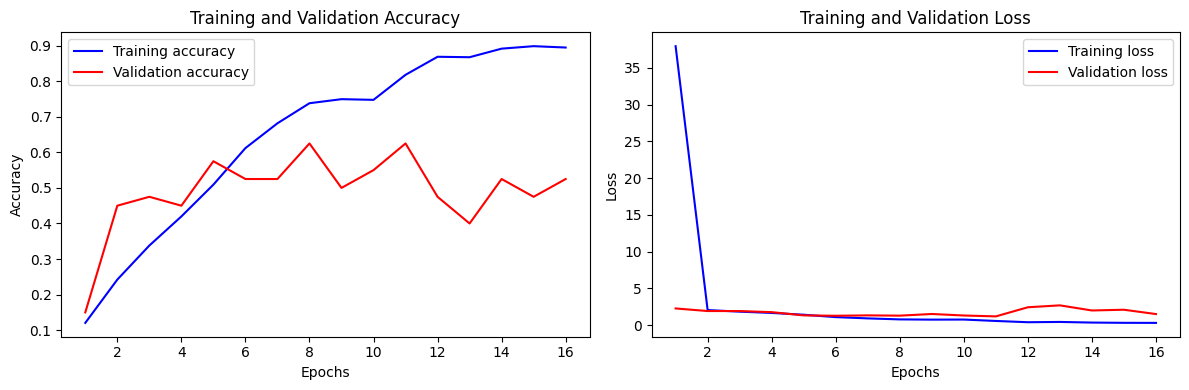

In [25]:
# Dibujamos las gráficas de la accuracy y la loss, para training y validación
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
predictions=model.evaluate(test_generator)

3/3 [==============================] - 0s 57ms/step - loss: 1.8618 - accuracy: 0.5800


In [27]:
true_labels = test_generator.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(test_generator), axis=1)

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

3/3 [==============================] - 0s 103ms/step
Classification Report:
                   precision    recall  f1-score   support

        baseball       0.22      0.40      0.29         5
      basketball       1.00      0.40      0.57         5
         bowling       0.00      0.00      0.00         5
          boxing       0.75      0.60      0.67         5
        football       1.00      0.60      0.75         5
formula 1 racing       0.56      1.00      0.71         5
          hockey       0.80      0.80      0.80         5
            polo       0.50      1.00      0.67         5
        swimming       0.67      0.80      0.73         5
          tennis       1.00      0.20      0.33         5

        accuracy                           0.58        50
       macro avg       0.65      0.58      0.55        50
    weighted avg       0.65      0.58      0.55        50

